In [1]:
from utils.wav2vec import load
import os
os.environ["KERAS_BACKEND"] = "torch"

### Wav2vec + RNN

In [2]:
features, labels = load()

In [3]:
from keras import Input, Sequential, layers, optimizers
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=False)

X_train.shape

(480, 14999, 768)

In [4]:
# Define the RNN model using Input layer
model = Sequential()

# Input layer
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# Convolutional layer block 1
model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Dropout(0.3))

# Convolutional layer block 2
model.add(layers.Conv1D(filters=128, kernel_size=3, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Dropout(0.3))

# Convolutional layer block 3
model.add(layers.Conv1D(filters=256, kernel_size=3, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Dropout(0.3))

# Recurrent layer
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)))

# Fully connected layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(len(set(y_train)), activation='softmax'))

# Compile the model using sparse categorical crossentropy
model.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [5]:
do_train = False
if do_train:
    # Train the model
    history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))
    # Save the model
    model.save('rnn_model.keras')
else:
    from keras import models
    model = models.load_model('rnn_model.keras')

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 104s 7s/step - accuracy: 0.4737 - loss: 0.7528 - val_accuracy: 0.5000 - val_loss: 0.6959
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 106s 7s/step - accuracy: 0.5293 - loss: 0.6881 - val_accuracy: 0.5000 - val_loss: 0.7158
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 103s 7s/step - accuracy: 0.6704 - loss: 0.6348 - val_accuracy: 0.4833 - val_loss: 0.7943
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 104s 7s/step - accuracy: 0.7035 - loss: 0.5366 - val_accuracy: 0.4583 - val_loss: 0.9193
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step - accuracy: 0.8258 - loss: 0.4098 - val_accuracy: 0.4917 - val_loss: 1.6073
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 104s 7s/step - accuracy: 0.7959 - loss: 0.4226 - val_accuracy: 0.5500 - val_loss: 1.1820
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 107s 7s/step - accuracy: 0.9115 - loss: 0.2340 - val_accuracy: 0.5250 - val_loss: 1.4180
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 104s 7s/step - accuracy: 0.9322 - loss: 0.1978 - val_accuracy: 0.4833 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.4387 - loss: 3.8827
Test Loss: 3.9630537033081055
Test Accuracy: 0.42500001192092896


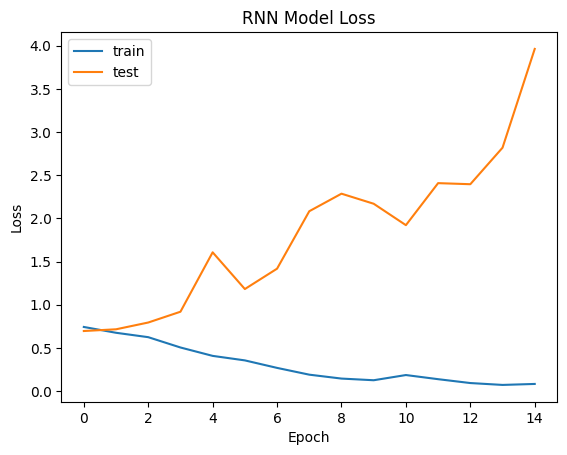

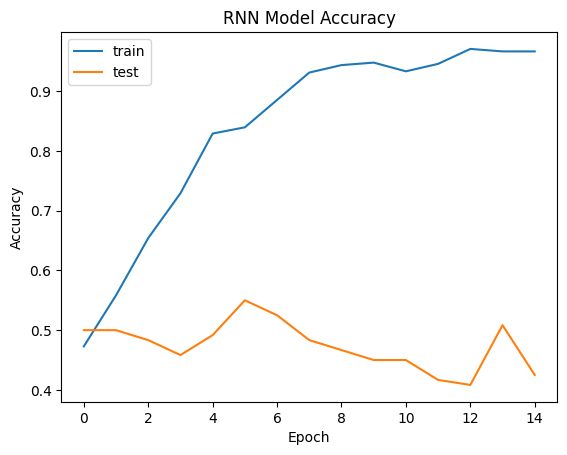

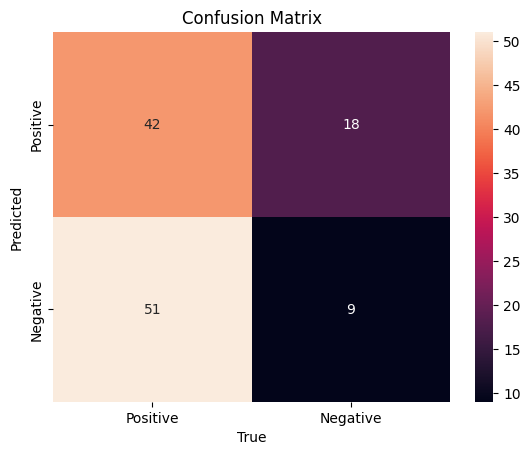

In [6]:
# Plot the training history
import matplotlib.pyplot as plt

# Evaluate the model, hide the output
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

if do_train:
    plt.figure()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('RNN Model Loss')
    plt.legend()
    plt.figure()
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('RNN Model Accuracy')
    plt.legend()
    plt.show()

# Predicting the class of new data
predictions = model.predict(X_test, verbose=0)
predicted_labels = predictions.argmax(axis=1)  # Convert probabilities to class labels

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
class_labels = ['Positive', 'Negative']
cm = confusion_matrix(y_test, predicted_labels)
cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtain prediction probabilities (this returns probabilities for each class)
predictions_prob = model.predict(X_test, verbose=0)

# For binary classification, get probabilities of the positive class (class 1)
fpr, tpr, thresholds = roc_curve(y_test, predictions_prob[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-specificity')
plt.ylabel('sensitivity')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()